<a href="https://colab.research.google.com/github/tamandakaunda-15/Formative2_HMMs/blob/main/Hidden_Markov_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hmmlearn scikit-learn

import os
import pandas as pd
import numpy as np
import re
from scipy.stats import pearsonr
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import StandardScaler
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 2.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DRIVE_PATH = '/content/drive/MyDrive/Formative_2/HMM_Project_Data_UNPROCESSED/'

print(f"\nConfiguration complete. Data will be loaded from: {DRIVE_PATH}")


Configuration complete. Data will be loaded from: /content/drive/MyDrive/Formative_2/HMM_Project_Data_UNPROCESSED/


##Feature Extraction

In [4]:
#  Feature Extraction Functions

WINDOW_SIZE_HZ = 100 # sampling rate of 100 Hz

def extract_features(merged_df):
    """
    Extracts 19 key features from a single merged 10-second sample.
    (Time-Domain, Magnitude, Correlation, Frequency-Domain)
    """
    features = {}

    accel_cols = ['Acc_x', 'Acc_y', 'Acc_z']
    gyro_cols = ['Gyro_x', 'Gyro_y', 'Gyro_z']
    all_cols = accel_cols + gyro_cols

    df = merged_df.copy()
    N = len(df)

    if N == 0:
        # Handle empty DataFrame case (return zeros)
        feature_names = [f'{c}_mean' for c in all_cols] + [f'{c}_std' for c in all_cols] + \
                        ['SMA', 'Acc_xy_corr', 'Acc_xz_corr', 'Acc_yz_corr'] + \
                        [f'{c}_dom_freq' for c in all_cols]
        return pd.Series(0.0, index=feature_names)

    # 1. Time-Domain Features (Mean, Standard Deviation)
    for col in all_cols:
        features[f'{col}_mean'] = df[col].mean()
        features[f'{col}_std'] = df[col].std()

    # 2. Combined/Magnitude Features
    df['Acc_Mag'] = np.sqrt(df['Acc_x']**2 + df['Acc_y']**2 + df['Acc_z']**2)
    features['SMA'] = df['Acc_Mag'].abs().mean()

    # 3. Correlation between Accelerometer Axes
    try:
        features['Acc_xy_corr'] = pearsonr(df['Acc_x'], df['Acc_y'])[0]
        features['Acc_xz_corr'] = pearsonr(df['Acc_x'], df['Acc_z'])[0]
        features['Acc_yz_corr'] = pearsonr(df['Acc_y'], df['Acc_z'])[0]
    except ValueError:
        features['Acc_xy_corr'] = 0.0
        features['Acc_xz_corr'] = 0.0
        features['Acc_yz_corr'] = 0.0

    # 4. Frequency-Domain Features (Dominant Frequency)
    for col in all_cols:
        signal = df[col].values
        yf = fft(signal)
        power_spectrum = np.abs(yf[:N//2])**2
        xf = fftfreq(N, 1/WINDOW_SIZE_HZ)[:N//2]

        # Dominant Frequency (skip DC component)
        if len(power_spectrum) > 1:
            dominant_freq_index = np.argmax(power_spectrum[1:]) + 1
            features[f'{col}_dom_freq'] = xf[dominant_freq_index]
        else:
            features[f'{col}_dom_freq'] = 0.0

    return pd.Series(features)

def process_all_samples(base_dir):
    """Loads, merges, extracts features, and normalizes the entire dataset."""
    all_features = []
    all_labels = []

    activities = ['standing', 'walking', 'jumping', 'still']

    for item_name in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, item_name)

        if os.path.isdir(folder_path):

            # Individual Activity Label Extraction
            name = item_name.lower()
            label = None
            for act in activities:
                match = re.search(r'^{}|[_-]{}'.format(act, act), name)
                if match:
                    label = act.capitalize()
                    break

            if label is None:
                continue

            #  Loading and Merging CSVs (Accelerometer and Gyroscope) for each activity sample
            try:
                accel_path = os.path.join(folder_path, 'Accelerometer.csv')
                gyro_path = os.path.join(folder_path, 'Gyroscope.csv')

                # Load and rename columns
                accel_df = pd.read_csv(accel_path).rename(columns={'x': 'Acc_x', 'y': 'Acc_y', 'z': 'Acc_z'})
                gyro_df = pd.read_csv(gyro_path).rename(columns={'x': 'Gyro_x', 'y': 'Gyro_y', 'z': 'Gyro_z'})

                # MERGING THE 2 CVS into dataframes
                merged_df = pd.merge(accel_df, gyro_df, on=['time', 'seconds_elapsed'], how='inner')

                # Feature Extraction
                features = extract_features(merged_df)

                all_features.append(features)
                all_labels.append(label)

            except FileNotFoundError:
                print(f"Skipping: Missing files in {item_name}")
            except Exception as e:
                print(f"Skipping: Error processing {item_name}: {e}")

    feature_matrix = pd.DataFrame(all_features)
    label_series = pd.Series(all_labels, name='Activity_Label')

    # --- Feature Normalization (Z-score standardisation) ---
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feature_matrix)
    normalized_df = pd.DataFrame(normalized_features, columns=feature_matrix.columns)

    return normalized_df, label_series

In [5]:
# Run the full processing pipeline
feature_matrix, activity_labels = process_all_samples(DRIVE_PATH)

print(f"Successfully processed {len(feature_matrix)} total samples.")
print("Feature Matrix Shape:", feature_matrix.shape)
print("\nActivity Distribution:")
print(activity_labels.value_counts())



Successfully processed 51 total samples.
Feature Matrix Shape: (51, 22)

Activity Distribution:
Activity_Label
Walking     16
Standing    12
Still       12
Jumping     11
Name: count, dtype: int64


## Defining Model Components

In [6]:
# Cell 1: Prepare All Data for Training

# Use ALL samples for training (no split)
X_train_all = feature_matrix.values
y_train_labels = activity_labels.values

# Create label mapping
label_map = {name: i for i, name in enumerate(activity_labels.unique())}
reverse_label_map = {v: k for k, v in label_map.items()}

print(f"Training with ALL {len(X_train_all)} samples")
print(f"Number of features: {X_train_all.shape[1]}")
print(f"\nActivity distribution:")
print(activity_labels.value_counts())
print(f"\nLabel mapping: {label_map}")

Training with ALL 51 samples
Number of features: 22

Activity distribution:
Activity_Label
Walking     16
Standing    12
Still       12
Jumping     11
Name: count, dtype: int64

Label mapping: {'Jumping': 0, 'Standing': 1, 'Walking': 2, 'Still': 3}


## Building Model

In [7]:
# Cell 2: Initialize and Train HMM Model

n_states = len(label_map)
n_features = X_train_all.shape[1]

print(f"\nTraining Gaussian HMM...")
print(f"  - Hidden states: {n_states}")
print(f"  - Features: {n_features}")
print(f"  - Training samples: {len(X_train_all)}")

# Initialize and train model
model = hmm.GaussianHMM(
    n_components=n_states,
    covariance_type="diag",
    n_iter=100,
    tol=1e-4,
    random_state=42,
    verbose=True
)

# Train using Baum-Welch
model.fit(X_train_all)

print("\n✓ Training Complete!")
print(f"  - Final log-likelihood: {model.score(X_train_all):.2f}")
print(f"  - Converged: {model.monitor_.converged}")
print(f"  - Iterations: {model.monitor_.iter}")


Training Gaussian HMM...
  - Hidden states: 4
  - Features: 22
  - Training samples: 51

✓ Training Complete!
  - Final log-likelihood: 291.52
  - Converged: True
  - Iterations: 9


         1   -1471.45110322             +nan
         2     -36.90493191   +1434.54617131
         3     277.01591126    +313.92084317
         4     284.23724339      +7.22133213
         5     285.88178685      +1.64454346
         6     289.92606578      +4.04427893
         7     291.50045447      +1.57438869
         8     291.51889804      +0.01844357
         9     291.51896277      +0.00006473


Initial State Probabilities (π):
  Jumping: 1.0000
  Standing: 0.0000
  Walking: 0.0000
  Still: 0.0000


NameError: name 'sns' is not defined

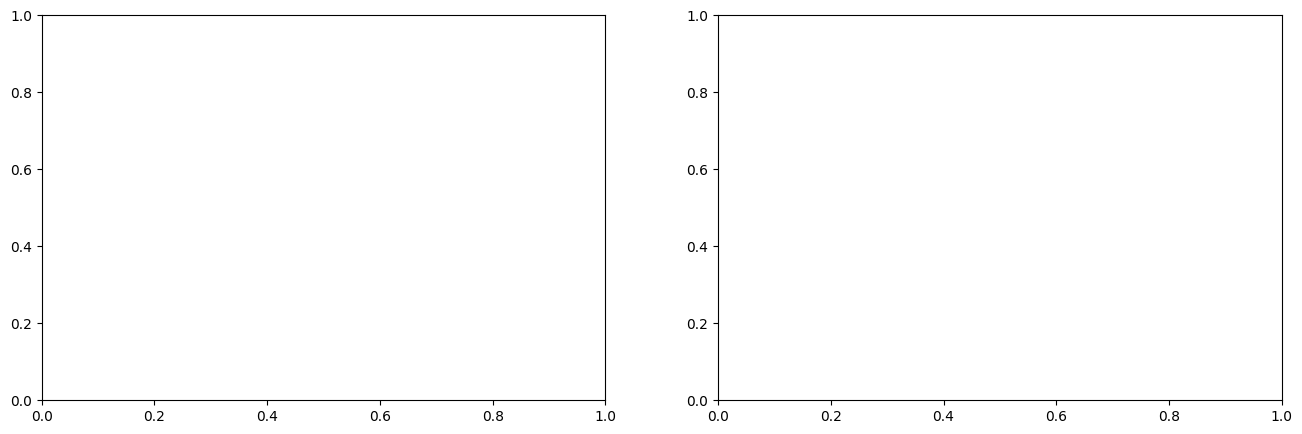

In [13]:
# Cell 3: Visualize HMM Parameters

# Extract parameters
transition_matrix = model.transmat_
initial_probs = model.startprob_
emission_means = model.means_

# Display initial probabilities
print("Initial State Probabilities (π):")
for state_num, prob in enumerate(initial_probs):
    print(f"  {reverse_label_map[state_num]}: {prob:.4f}")

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. Transition Matrix Heatmap
sns.heatmap(transition_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=list(reverse_label_map.values()),
            yticklabels=list(reverse_label_map.values()),
            ax=axes[0], cbar_kws={'label': 'Probability'})
axes[0].set_title('Transition Probability Matrix', fontweight='bold', fontsize=12)
axes[0].set_xlabel('To State')
axes[0].set_ylabel('From State')

# 2. Emission Means
emission_df = pd.DataFrame(emission_means.T,
                           columns=list(reverse_label_map.values()))
sns.heatmap(emission_df, cmap='coolwarm', center=0, ax=axes[1],
            cbar_kws={'label': 'Normalized Value'})
axes[1].set_title('Emission Probability Means (Features per State)',
                  fontweight='bold', fontsize=12)
axes[1].set_xlabel('Activity State')
axes[1].set_ylabel('Feature Index')

plt.tight_layout()
plt.show()

Viterbi Decoding Results:
  - Log-probability: 291.52
  - Decoded 51 samples


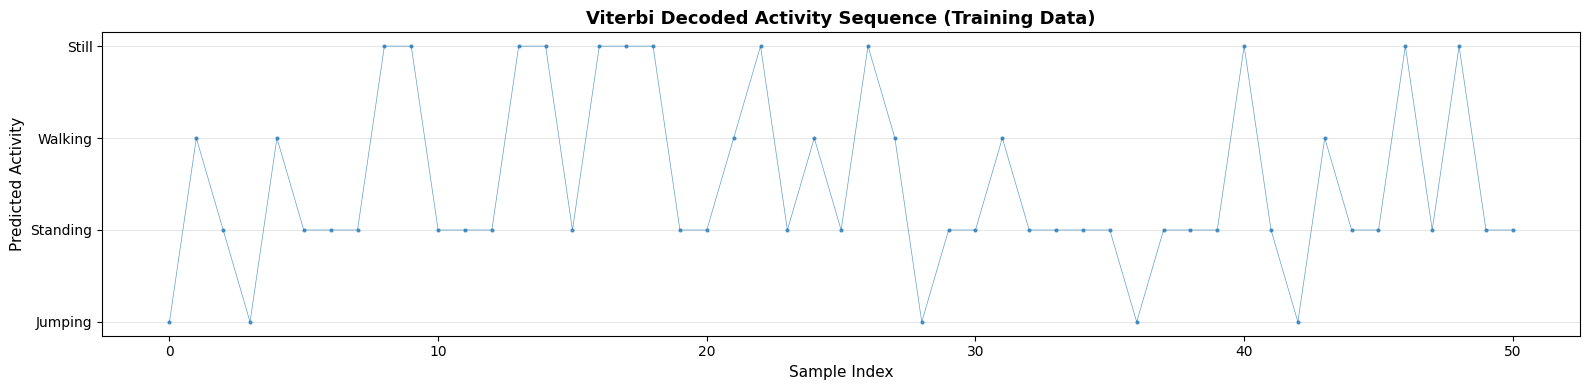

In [11]:
# Cell 4: Apply Viterbi Algorithm (Training Data Validation)

# Decode using Viterbi
logprob, predicted_states = model.decode(X_train_all, algorithm='viterbi')

print(f"Viterbi Decoding Results:")
print(f"  - Log-probability: {logprob:.2f}")
print(f"  - Decoded {len(predicted_states)} samples")

# Visualize decoded sequence
plt.figure(figsize=(16, 4))
plt.plot(predicted_states, marker='o', linestyle='-', markersize=2,
         linewidth=0.5, alpha=0.7)
plt.yticks(range(n_states), list(reverse_label_map.values()))
plt.xlabel('Sample Index', fontsize=11)
plt.ylabel('Predicted Activity', fontsize=11)
plt.title('Viterbi Decoded Activity Sequence (Training Data)',
          fontsize=13, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Model Evaluation

In [ ]:
# Cell 5: Load and Evaluate New Test Data

def load_and_evaluate_test_data(test_folders, model, label_map, reverse_label_map):
    """
    Load new test samples, extract features, predict, and evaluate.

    Parameters:
    -----------
    test_folders : list of tuples
        Each tuple: (folder_path, true_activity_label)
        Example: [('/path/to/test1', 'Walking'), ('/path/to/test2', 'Jumping')]
    """
    test_features = []
    test_labels = []

    print(f"Loading {len(test_folders)} test samples...\n")

    for folder_path, true_label in test_folders:
        try:
            # Load CSVs
            accel_path = os.path.join(folder_path, 'Accelerometer.csv')
            gyro_path = os.path.join(folder_path, 'Gyroscope.csv')

            accel_df = pd.read_csv(accel_path).rename(columns={
                'x': 'Acc_x', 'y': 'Acc_y', 'z': 'Acc_z'
            })
            gyro_df = pd.read_csv(gyro_path).rename(columns={
                'x': 'Gyro_x', 'y': 'Gyro_y', 'z': 'Gyro_z'
            })

            # Merge and extract features
            merged_df = pd.merge(accel_df, gyro_df,
                                on=['time', 'seconds_elapsed'], how='inner')
            features = extract_features(merged_df)

            test_features.append(features)
            test_labels.append(true_label)

            print(f"✓ Loaded: {os.path.basename(folder_path)} ({true_label})")

        except Exception as e:
            print(f"✗ Error loading {folder_path}: {e}")

    if len(test_features) == 0:
        print("\n⚠ No test data loaded!")
        return None, None, None, None

    # Convert to arrays
    X_test = np.array(test_features)
    y_test_names = np.array(test_labels)
    y_test_num = np.array([label_map[label] for label in y_test_names])

    # Predict using Viterbi
    _, y_pred = model.decode(X_test, algorithm='viterbi')

    print(f"\n✓ Prediction complete: {len(y_pred)} samples")

    return X_test, y_test_num, y_pred, y_test_names


# ============================================================================
# CONFIGURE YOUR TEST DATA HERE
# ============================================================================
# Format: (folder_path, true_activity_label)

TEST_DATA = [
    # Example format - UPDATE WITH YOUR ACTUAL PATHS:
    # ('/content/drive/MyDrive/Test_Data/walking_test_1', 'Walking'),
    # ('/content/drive/MyDrive/Test_Data/jumping_test_1', 'Jumping'),
    # ('/content/drive/MyDrive/Test_Data/standing_test_1', 'Standing'),
    # ('/content/drive/MyDrive/Test_Data/still_test_1', 'Still'),
]

# Run evaluation when test data is available
if len(TEST_DATA) > 0:
    X_test, y_test_num, y_pred, y_test_names = load_and_evaluate_test_data(
        TEST_DATA, model, label_map, reverse_label_map
    )
else:
    print("⚠ No test data configured. Update TEST_DATA list above.")
    print("\nSee instructions below for how to structure your test data.")

In [ ]:
# Cell 6: Calculate Performance Metrics

if len(TEST_DATA) > 0 and y_test_num is not None:

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_num, y_pred)

    # Calculate metrics per class
    metrics = []
    for i in range(n_states):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        accuracy = (TP + TN) / cm.sum()

        metrics.append({
            'State (Activity)': reverse_label_map[i],
            'Number of Samples': int(cm[i, :].sum()),
            'Sensitivity': f"{sensitivity:.4f}",
            'Specificity': f"{specificity:.4f}",
            'Overall Accuracy': f"{accuracy:.4f}"
        })

    metrics_df = pd.DataFrame(metrics)

    # Display results
    print("="*80)
    print("MODEL EVALUATION ON UNSEEN DATA")
    print("="*80)
    print(metrics_df.to_string(index=False))

    overall_acc = (y_pred == y_test_num).mean()
    print(f"\n{'='*80}")
    print(f"OVERALL ACCURACY: {overall_acc:.4f} ({overall_acc*100:.2f}%)")
    print(f"{'='*80}")

    # Visualize confusion matrix
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(reverse_label_map.values()),
                yticklabels=list(reverse_label_map.values()),
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix', fontweight='bold')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Prediction visualization
    x_pos = np.arange(len(y_pred))
    axes[1].scatter(x_pos, y_test_num, label='Actual', s=100, alpha=0.6, marker='o')
    axes[1].scatter(x_pos, y_pred, label='Predicted', s=100, alpha=0.6, marker='x')
    axes[1].set_yticks(range(n_states))
    axes[1].set_yticklabels(list(reverse_label_map.values()))
    axes[1].set_xlabel('Test Sample Index')
    axes[1].set_ylabel('Activity')
    axes[1].set_title('Actual vs Predicted Activities', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test_num, y_pred,
                                target_names=list(reverse_label_map.values())))
else:
    print("Configure TEST_DATA in Cell 5 to run evaluation")